#**Training d-DNN and e-DNNs using CPR coincidences over the ocean**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
import scipy.io
import os

## **1. Data**

### **1.1 Data Loading and Organizing**

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_CPR_ocean.mat','r')
list(f.keys())

['X_ocean_trn_detection',
 'X_ocean_trn_retrieval',
 'X_ocean_tst_detection',
 'X_ocean_tst_retrieval',
 'y_ocean_trn_detection',
 'y_ocean_trn_retrieval',
 'y_ocean_tst_detection',
 'y_ocean_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_ocean_trn_detection'])
y_trn_detection = np.transpose(f['y_ocean_trn_detection'])
X1_tst_detection = np.transpose(f['X_ocean_tst_detection'])
y_tst_detection = np.transpose(f['y_ocean_tst_detection'])

X1_trn_retrieval = np.transpose(f['X_ocean_trn_retrieval'])
y_trn_retrieval = np.transpose(f['y_ocean_trn_retrieval'])
X1_tst_retrieval = np.transpose(f['X_ocean_tst_retrieval'])
y_tst_retrieval = np.transpose(f['y_ocean_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_trn_retrieval.astype('float64')
X1_tst_retrieval.astype('float64')
y_trn_retrieval.astype('float64')
y_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_retrieval = X1_trn_retrieval.mean(axis=0)
X2_trn_retrieval = X1_trn_retrieval-mean_retrieval
std_retrieval = X1_trn_retrieval.std(axis=0)
X_trn_retrieval = X2_trn_retrieval/std_retrieval
X2_tst_retrieval = X1_tst_retrieval-mean_retrieval
X_tst_retrieval = X2_tst_retrieval/std_retrieval

To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==5:
        n_snow+=1
        t_train[i]=2
    if label==3:
        n_rain+=1  
        t_train[i]=1
    if label==0:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==5:
        n_snow+=1
        t_test[i]=2
    if label==3:
        n_rain+=1  
        t_test[i]=1
    if label==0:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 39225
Num. of rainfall: 39117
Num. of clear-sky: 78384

***Testing Dataset:

Num. of snowfall: 16734
Num. of rainfall: 16866
Num. of clear-sky: 33569


In [ ]:
from tensorflow.keras.utils import to_categorical
t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

### **2.1 - Detection Network (d-DNN)**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.
model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
# Training the network (batch_size= 500, epoch = 500)

print('\nFitting DNN (Detection Module):\n')
batch_size1 = 500
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=400,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/400
251/251 [==============================] - 1s 4ms/step - loss: 0.9023 - recall: 0.1518 - val_loss: 0.6722 - val_recall: 0.6543
Epoch 2/400
251/251 [==============================] - 1s 3ms/step - loss: 0.4911 - recall: 0.7967 - val_loss: 0.3790 - val_recall: 0.8465
Epoch 3/400
251/251 [==============================] - 1s 3ms/step - loss: 0.3442 - recall: 0.8612 - val_loss: 0.3129 - val_recall: 0.8725
Epoch 4/400
251/251 [==============================] - 1s 3ms/step - loss: 0.2937 - recall: 0.8822 - val_loss: 0.2738 - val_recall: 0.8901
Epoch 5/400
251/251 [==============================] - 1s 3ms/step - loss: 0.2652 - recall: 0.8941 - val_loss: 0.2539 - val_recall: 0.8985
Epoch 6/400
251/251 [==============================] - 1s 3ms/step - loss: 0.2501 - recall: 0.9007 - val_loss: 0.2429 - val_recall: 0.9015
Epoch 7/400
251/251 [==============================] - 1s 3ms/step - loss: 0.2403 - recall: 0.9044 - val_loss: 0.2357 - val_recall: 

251/251 [==============================] - 1s 3ms/step - loss: 0.1787 - recall: 0.9284 - val_loss: 0.1804 - val_recall: 0.9278
Epoch 117/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1787 - recall: 0.9282 - val_loss: 0.1812 - val_recall: 0.9275
Epoch 118/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1785 - recall: 0.9283 - val_loss: 0.1857 - val_recall: 0.9244
Epoch 119/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1786 - recall: 0.9285 - val_loss: 0.1800 - val_recall: 0.9278
Epoch 120/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1783 - recall: 0.9285 - val_loss: 0.1802 - val_recall: 0.9277
Epoch 121/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1782 - recall: 0.9286 - val_loss: 0.1813 - val_recall: 0.9271
Epoch 122/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1781 - recall: 0.9283 - val_loss: 0.1805 - val_recall: 0.9277
Epoch 123/400
251/251 [====

251/251 [==============================] - 1s 3ms/step - loss: 0.1739 - recall: 0.9306 - val_loss: 0.1782 - val_recall: 0.9292
Epoch 175/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1737 - recall: 0.9304 - val_loss: 0.1777 - val_recall: 0.9297
Epoch 176/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1737 - recall: 0.9304 - val_loss: 0.1759 - val_recall: 0.9301
Epoch 177/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1738 - recall: 0.9302 - val_loss: 0.1766 - val_recall: 0.9302
Epoch 178/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1736 - recall: 0.9302 - val_loss: 0.1758 - val_recall: 0.9302
Epoch 179/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1735 - recall: 0.9305 - val_loss: 0.1771 - val_recall: 0.9305
Epoch 180/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1734 - recall: 0.9305 - val_loss: 0.1764 - val_recall: 0.9295
Epoch 181/400
251/251 [====

Epoch 232/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1703 - recall: 0.9316 - val_loss: 0.1748 - val_recall: 0.9316
Epoch 233/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1700 - recall: 0.9321 - val_loss: 0.1736 - val_recall: 0.9315
Epoch 234/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1701 - recall: 0.9318 - val_loss: 0.1736 - val_recall: 0.9320
Epoch 235/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1699 - recall: 0.9320 - val_loss: 0.1748 - val_recall: 0.9312
Epoch 236/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1699 - recall: 0.9318 - val_loss: 0.1737 - val_recall: 0.9317
Epoch 237/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1700 - recall: 0.9318 - val_loss: 0.1727 - val_recall: 0.9318
Epoch 238/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1700 - recall: 0.9317 - val_loss: 0.1735 - val_recall: 0.9314
Epoch 239/400

Epoch 290/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1677 - recall: 0.9328 - val_loss: 0.1722 - val_recall: 0.9322
Epoch 291/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1675 - recall: 0.9330 - val_loss: 0.1716 - val_recall: 0.9337
Epoch 292/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1676 - recall: 0.9325 - val_loss: 0.1725 - val_recall: 0.9322
Epoch 293/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1676 - recall: 0.9327 - val_loss: 0.1724 - val_recall: 0.9322
Epoch 294/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1674 - recall: 0.9325 - val_loss: 0.1726 - val_recall: 0.9318
Epoch 295/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1674 - recall: 0.9326 - val_loss: 0.1713 - val_recall: 0.9336
Epoch 296/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1674 - recall: 0.9328 - val_loss: 0.1711 - val_recall: 0.9328
Epoch 297/400

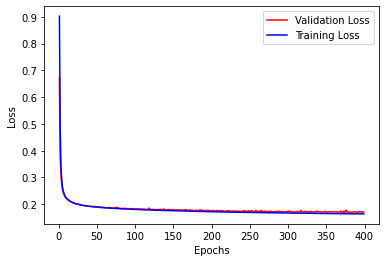

In [ ]:
# Plotting the variation of loss function on both training and validation set: 

import matplotlib.pyplot as plt

val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 400)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Testing the trained network over the testset.
predictions_label = model_detection.predict(X_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 0
precip_r= 1
precip_s= 2

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Ocean:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Ocean:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Ocean:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Ocean:

Precision:  0.9122570826504331
Accuracy:  0.9585857834015631
Recall (TPR):  0.9239388190656865
False Alarm (FPR):  0.029797046136720535

F1 Score:  0.9180607917059378
----------------------------

 For Snwofall Detection Over Ocean:

Precision:  0.9280013779640581
Accuracy:  0.9728023818384816
Recall (TPR):  0.9657624282982792
False Alarm (FPR):  0.02486171414976506

F1 Score:  0.9465054314408692
----------------------------

 For Model Detection Over Ocean:

Precision:  0.9314774841831038
Recall (TPR):  0.9314774841831038

F1 Score:  0.9314774841831038


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

135/135 [==============================] - 0s 517us/step - loss: 0.1702 - recall: 0.9315


[0.17021916806697845, 0.9315129518508911]

## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval**

In [ ]:
# Parameters
hidden_units = 60
dropout = 0

# OCEAN
model_retrieval = Sequential()

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(1))
model_retrieval.add(Activation('relu'))

In [ ]:
model_retrieval.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 500
history_retrieval = model_retrieval.fit(X_trn_retrieval, y_trn_retrieval, epochs=400,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Snow):

Epoch 1/400
251/251 [==============================] - 1s 3ms/step - loss: 0.1625 - mean_absolute_error: 0.0708 - val_loss: 0.1382 - val_mean_absolute_error: 0.0539
Epoch 2/400
251/251 [==============================] - 1s 2ms/step - loss: 0.1277 - mean_absolute_error: 0.0470 - val_loss: 0.1232 - val_mean_absolute_error: 0.0422
Epoch 3/400
251/251 [==============================] - 1s 2ms/step - loss: 0.1161 - mean_absolute_error: 0.0403 - val_loss: 0.1142 - val_mean_absolute_error: 0.0382
Epoch 4/400
251/251 [==============================] - 1s 2ms/step - loss: 0.1087 - mean_absolute_error: 0.0369 - val_loss: 0.1084 - val_mean_absolute_error: 0.0356
Epoch 5/400
251/251 [==============================] - 1s 2ms/step - loss: 0.1038 - mean_absolute_error: 0.0347 - val_loss: 0.1044 - val_mean_absolute_error: 0.0343
Epoch 6/400
251/251 [==============================] - 1s 2ms/step - loss: 0.1005 - mean_absolute_error: 0.0332 - val_loss: 0.1018 - v

251/251 [==============================] - 0s 2ms/step - loss: 0.0822 - mean_absolute_error: 0.0242 - val_loss: 0.0877 - val_mean_absolute_error: 0.0259
Epoch 100/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0820 - mean_absolute_error: 0.0241 - val_loss: 0.0877 - val_mean_absolute_error: 0.0259
Epoch 101/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0820 - mean_absolute_error: 0.0241 - val_loss: 0.0876 - val_mean_absolute_error: 0.0259
Epoch 102/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0822 - mean_absolute_error: 0.0241 - val_loss: 0.0876 - val_mean_absolute_error: 0.0258
Epoch 103/400
251/251 [==============================] - 0s 2ms/step - loss: 0.0819 - mean_absolute_error: 0.0241 - val_loss: 0.0879 - val_mean_absolute_error: 0.0258
Epoch 104/400
251/251 [==============================] - 0s 2ms/step - loss: 0.0821 - mean_absolute_error: 0.0241 - val_loss: 0.0877 - val_mean_absolute_error: 0.0262
Epoch 105/40

251/251 [==============================] - 1s 2ms/step - loss: 0.0799 - mean_absolute_error: 0.0233 - val_loss: 0.0870 - val_mean_absolute_error: 0.0254
Epoch 198/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0801 - mean_absolute_error: 0.0233 - val_loss: 0.0869 - val_mean_absolute_error: 0.0255
Epoch 199/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0800 - mean_absolute_error: 0.0232 - val_loss: 0.0869 - val_mean_absolute_error: 0.0254
Epoch 200/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0800 - mean_absolute_error: 0.0233 - val_loss: 0.0870 - val_mean_absolute_error: 0.0254
Epoch 201/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0801 - mean_absolute_error: 0.0233 - val_loss: 0.0871 - val_mean_absolute_error: 0.0253
Epoch 202/400
251/251 [==============================] - 1s 2ms/step - loss: 0.0797 - mean_absolute_error: 0.0232 - val_loss: 0.0871 - val_mean_absolute_error: 0.0253
Epoch 203/40

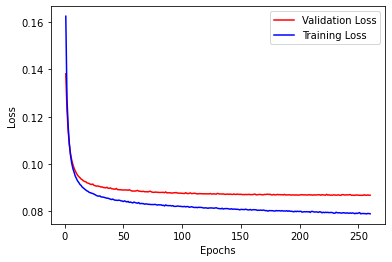

In [ ]:
val_loss = history_retrieval.history["val_loss"]
loss = history_retrieval.history["loss"]

epochs = range(1, 261)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval.predict(X_tst_retrieval)

In [ ]:
model_retrieval.evaluate(X_tst_retrieval, y_tst_retrieval, batch_size = batch_size2)

135/135 [==============================] - 0s 702us/step - loss: 0.0958 - mean_absolute_error: 0.0280


[0.09576115757226944, 0.028010044246912003]

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\CPR\Ocean\model_dtc',save_format='h5')
model_retrieval.save('Models\CPR\Ocean\model_snow',save_format='h5')
fp_CPR_ocean = 'Models/CPR/Ocean/files_CPR_ocean.mat'
scipy.io.savemat(fp_CPR_ocean, {'mean_detection_CPR_ocean': mean_detection,'std_detection_CPR_ocean':std_detection,
                               'mean_snow_retrieval_CPR_ocean': mean_retrieval,'std_snow_retrieval_CPR_ocean':std_retrieval})